# Continuous normalizing flows

In [1]:
from functools import partial

import jax

from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import math
from tensorflow_probability.substrates import jax as tfp

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The Dataset

(-2.0, 2.0)

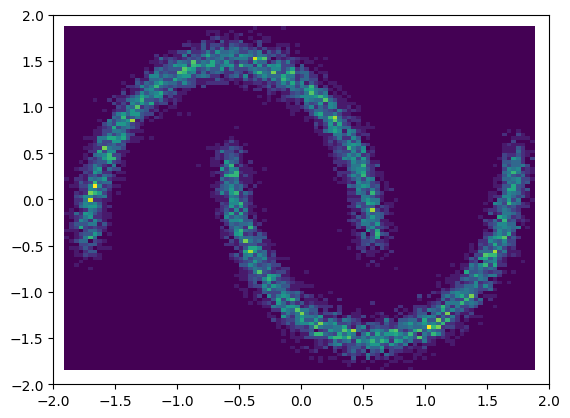

In [2]:
n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## CNFs

The evolution of the log-density follows the instantaneous change-of-variables formula:
$$\frac{\partial \log p({z}(t))}{\partial t}=-\operatorname{Tr}\left(\frac{\partial f}{\partial {z}(t)}\right)$$

Get total change in log-density by integrating across time:
$$\log p\left({z}\left(t_1\right)\right)=\log p\left({z}\left(t_0\right)\right)-\int_{t_0}^{t_1} \operatorname{Tr}\left(\frac{\partial f}{\partial {z}(t)}\right) d t$$

We can get an unbiased estimate of the trace of a matrix by taking a double product of that matrix with a noise vector.
$$\operatorname{Tr}(A)=E_{p({\epsilon})}\left[{\epsilon}^T A {\epsilon}\right]$$

In [130]:
class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 3

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

## Implementation

Adapted from [Diffrax](https://docs.kidger.site/diffrax/examples/continuous_normalising_flow/).

In [154]:
def logp_exact(t, y, args):
    """ Compute trace directly.
    """
    y, _ = y
    _, func = args
    t = np.atleast_1d(t)

    fn = lambda y: func(np.concatenate([y, t]))  # Augmented function
    f, f_vjp = jax.vjp(fn, y)  # VJPs can be computed at the ~same cost as computing f through reverse-mode AD

    # Compute trace
    (size,) = y.shape
    (dfdy,) = jax.vmap(f_vjp)(np.eye(size))
    logp = np.trace(dfdy)
    return f, logp

def logp_approx(t, y, args):
    """ Approx. trace using Hutchinson's trace estimator.
    """
    y, _ = y
    z, func = args
    t = np.atleast_1d(t)
    
    fn = lambda y: func(np.concatenate([y, t]))  # Augmented function
    f, f_vjp = jax.vjp(fn, y) # VJPs can be computed at the ~same cost as computing f through reverse-mode AD
    
    # Trace estimator
    (z_dfdy,) = f_vjp(z)
    logp = np.sum(z_dfdy * z)
    return f, logp

In [155]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

f = MLP(hidden_dim=64, out_dim=2, n_layers=3)
params = f.init(key, np.concatenate([x, t], axis=1))

In [160]:
t0 = 0.0
t1 = 1.0
dt0 = 1e-2
logp = 'exact'

# Runs backward-in-time to train the CNF
def loss_fn(params, y, f):
    if logp == 'exact':
        term = dfx.ODETerm(logp_exact)
    elif logp == 'approx':
        term = dfx.ODETerm(logp_approx)
    else:
        raise NotImplementedError
    solver = dfx.Heun()
    eps = jax.random.normal(key, y.shape)
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    func = lambda x: f.apply(params, x)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y, (eps, func))
    (z,), (delta_log_likelihood,) = sol.ys
    log_prob = delta_log_likelihood + tfp.distributions.Normal(loc=0., scale=1.).log_prob(z).sum()
    return - log_prob

jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x[:32], f)

Array([2.8278651, 3.5531049, 3.0163054, 2.1736321, 3.6329148, 2.7178998,
       3.4050603, 2.3750718, 3.4368873, 2.1709108, 2.2257757, 2.0318604,
       2.0849245, 1.9940656, 1.9154557, 3.6149201, 2.0848384, 2.0331614,
       2.1449957, 2.2508745, 4.032276 , 3.2739336, 3.3966024, 3.1662138,
       2.931527 , 3.6427534, 3.238077 , 3.1869493, 2.8708508, 2.8055973,
       3.1574476, 3.1925066], dtype=float32)

## Train

In [161]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

@partial(jax.jit, static_argnums=(2,))
def loss_fn_vmapped(params, x_batch, f):
    loss = jax.vmap(loss_fn, in_axes=(None, 0, None))(params, x_batch, f)
    return loss.mean()


In [162]:
n_steps = 1000
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, _ = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))

        x_batch = x[idx]
        
        loss, grads = jax.value_and_grad(loss_fn_vmapped)(params, x_batch, f)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s, val=1.7022799]


## Sampling

In [163]:
def single_sample_fn(params, key, n_dim=2):
    """ Produce single sample from the CNF by integrating forward.
    """
    z = jax.random.normal(key, (n_dim,))
    def func(t, x, args):
        t = np.atleast_1d(t)
        return f.apply(params, np.concatenate([x, t]))
    term = dfx.ODETerm(func)
    solver = dfx.Heun()
    sol = dfx.diffeqsolve(term, solver, t0, t1, dt0, z)
    (y,) = sol.ys
    return y

single_sample_fn(params, key)

Array([-0.01596396,  0.45728304], dtype=float64, weak_type=True)

In [164]:
sample_fn = partial(single_sample_fn, params)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

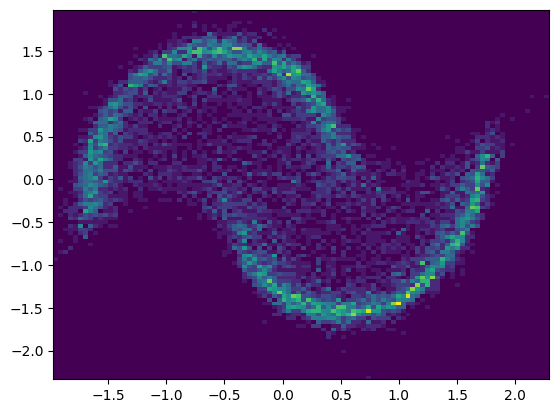

In [165]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100);